In [8]:
import torch
import seaborn as sns
sns.set_theme(style="darkgrid")

In [5]:
t_c = torch.tensor([0.5,  14.0, 15.0, 28.0, 11.0,  8.0,  3.0, -4.0,  6.0, 13.0, 21.0]) # in celcius
t_u = torch.tensor([35.7, 55.9, 58.2, 81.9, 56.3, 48.9, 33.9, 21.8, 48.4, 60.4, 68.4]) # in unknown unit

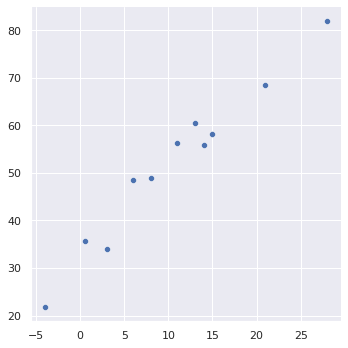

In [12]:
# We want a scatter plot. The relational plot function is more general, and uses a scatter plot as default
sns.relplot(x=t_c, y=t_u)

<AxesSubplot:>

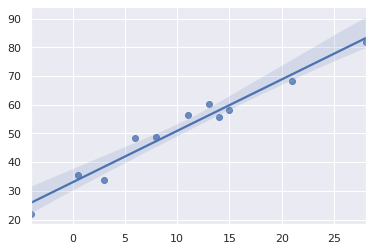

In [24]:
# plotting the regression line along with a 95% confidence interval
# for some reason, doesn't work well with tensors
sns.regplot(x=t_c.numpy(), y=t_u.numpy())